# ICP #
This notebook is all about ICP and it's different implementations. It should be visual and self - descriptive.

## Contents:
* [Overview](#Overview)
* [ICP based on SVD](#ICP-based-on-SVD)
* [Non linear Least squares based ICP](#Non-linear-Least-squares-based-ICP)
* [Using point to plane metric with Least Squares ICP](#Using-point-to-plane-metric-with-Least-Squares-ICP)
* [Dealing with outliers](#Dealing-with-outliers)

## Overview
Having two scans $P = \{p_i\}$ and $Q = \{q_i\}$ we want to find a transformation (rotation $R$ and translation $t$) to apply to $P$ to match $Q$ as good as possible. In the remainder of this notebook we will try to define what does "as good as possible mean" as well as ways to find such a transformation.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

### The way we will plot the data

In [2]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q
    # draw initial correspondeces
    corresp_lines = []
    for i, j in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

### Generate example data
Thoughout this notebook we will be working wigh generated data that looks like this:

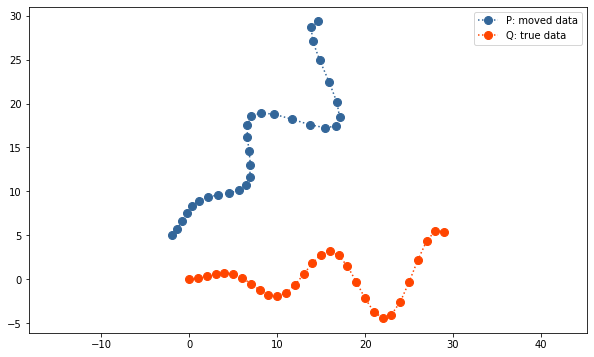

Shape of matrix P: (2, 30), Q:(2, 30)
And first element of P: [-2.  5.], Q:[0. 0.]
R_true: 
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
t_true: 
[[-2]
 [ 5]]


In [3]:
# initialize pertrubation rotation
angle = pi / 4
R_true = np.array([[cos(angle), -sin(angle)], 
                   [sin(angle),  cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.sin(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

plot_data(moved_data, true_data, "P: moved data", "Q: true data")
plt.show()

print (f"Shape of matrix P: {P.shape}, Q:{Q.shape}")
print (f"And first element of P: {P[:,0]}, Q:{Q[:,0]}")
print(f"R_true: \n{R_true}")
print(f"t_true: \n{t_true}")

### Correspondences computation
We compute correspondences from $P$ to $Q$, i.e. for every $p_i$ we search the closest $q_j$ to it.

In [4]:
def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

## ICP based on SVD

Tldr version. If the scans would match exactly, their cross-covariance would be identity. Therefore, we can iteratively optimize their cross-covariance to be as close as possible to an identity matrix by applying transformations to $P$. Let's dive into details. 

### Single iteration
In a single iteration we assume that the correspondences are known. We can compute the cross-correlation between the corresponding points. Let $C = \{\{i,j\}:p_i \leftrightarrow q_j\}$ be a set of all correspondences, also $|C| = N$. Then, the cross covariance $K$ is computed as:

\begin{eqnarray}
K &=& E [(q_i - \mu_Q)(p_i - \mu_P)^T] \\
&=& \frac{1}{N}\sum_{\{i,j\} \in C}{(q_i - \mu_Q)(p_i - \mu_P)^T} \\
&\sim& \sum_{\{i,j\} \in C}{(q_i - \mu_Q)(p_i - \mu_P)^T}
\end{eqnarray}

Each point has two dimentions, that is $p_i, q_j \in {\rm I\!R}^2$, thus cross covariance has the form of (we drop indices $i$ and $j$ for notation simplicity):

\begin{equation}
K =
  \begin{bmatrix}
    cov(p_x, q_x) & cov(p_x, q_y) \\
    cov(p_y, q_x) & cov(p_y, q_y)
  \end{bmatrix}
\end{equation}

-----
**Intuition:** Intuitevely, cross covariance tells us how a coordinate of point $q$ changes with the change of $p$ coordinate, i.e. $cov(p_x, q_x)$ tells us how the $x$ coordinate of $q$ will change with the change in $x$ coordinate of $p$ given that the points are corresponding. Ideal cross covariance matrix is an identity matrix, i.e., we want the $x$ coordinates to be ideally correlated between the scans $P$ and $Q$, while there should be no correlation between the $x$ coorinate of points from $P$ to the $y$ coordinate of points in $Q$. 
In our case, however, the position of $P$ is derived from the position of $Q$ through some rotation $R$ and translation $t$. Therefore, whenever we would move the scan $Q$, scan $P$ would move in a related way, but pertrubed through the rotation and translation applied, making the cross-covariance matrix non-identity.

----

Knowing the cross covariance we can compute its SVD decomposition:

\begin{equation}
\mathrm{SVD}(K) = USV^T
\end{equation}

The SVD decomposition gives us how to rotate our data to align it with its prominent direction with $UV^T$ and how to scale it with its singular values $S$. Therefore:

\begin{eqnarray}
R &=& UV^T \\
t &=& \mu_Q - R \mu_P
\end{eqnarray}

Furthur Reading: https://www.ltu.se/cms_fs/1.51590!/svd-fitting.pdf

#### Let's try this out: ####

### Make data centered

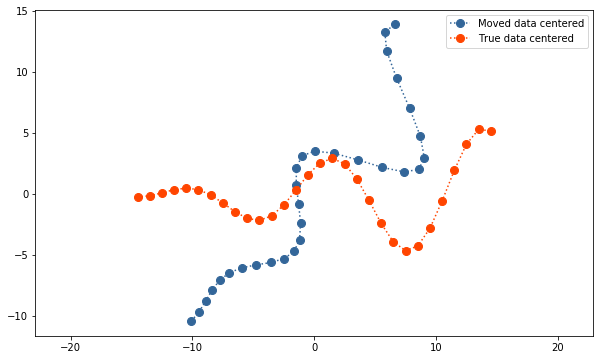

In [5]:
def center_data(data, exclude_indices=[]):
    reduced_data = np.delete(data, exclude_indices, axis=1)
    center = np.array([reduced_data.mean(axis=1)]).T
    return center, data - center

center_of_P, P_centered = center_data(P)
center_of_Q, Q_centered = center_data(Q)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()

### Compute correspondences

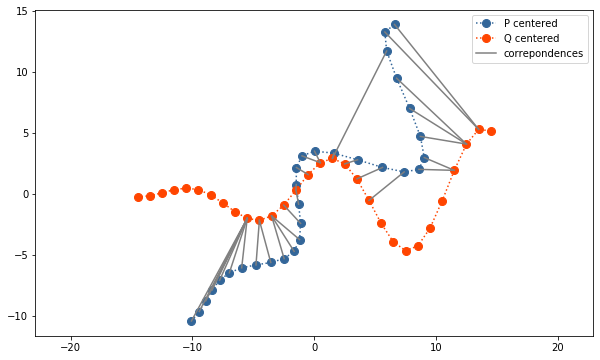

In [6]:
correspondences = get_correspondence_indices(P_centered, Q_centered)
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered')
draw_correspondeces(P_centered, Q_centered, correspondences, ax)
plt.show()

### Compute cross covariance

In [7]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((2, 2))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

cov, _ = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

[[1113.97274605 1153.71870122]
 [ 367.39948556  478.81890396]]


### Find $R$ and $t$ from SVD decomposition
Here we find SVD decomposition of the cross covariance matrix and apply the rotation to $Q$

In [8]:
U, S, V_T = np.linalg.svd(cov)
print(S)
R_found = U.dot(V_T)
t_found = center_of_Q - R_found.dot(center_of_P)
print("R_found =\n", R_found)
print("t_found =\n", t_found)

[1712.35558954   63.95608054]
R_found =
 [[ 0.89668479  0.44266962]
 [-0.44266962  0.89668479]]
t_found =
 [[  0.4278782 ]
 [-10.01055887]]


### Apply a single correction to $P$ and visualize the result
This is the result after just one iteration. Because our correspondences are not optimal, it is not a complete match.

[[  0.4278782 ]
 [-10.01055887]]
[[ 0.89668479  0.44266962]
 [-0.44266962  0.89668479]]


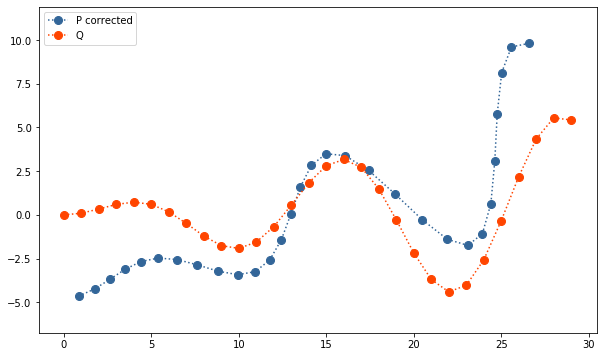

Squared diff: (P_corrected - Q) =  16.052894296516946


In [9]:
print(t_found)
print(R_found)
P_corrected = R_found.dot(P) + t_found
ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q')
plt.show()
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))

## Let's make it iterative
If we would know the correct correspondences from the start, we would be able to get the optimal solution in a single iteration. This is rarely the case and we need to iterate. That consists of the following steps:
1. Make data centered by subtracting the mean
2. Find correspondences for each point in $P$
3. Perform a single iteration by computing the cross-covariance matrix and performing the SVD
4. Apply the found rotation to $P$
5. Repeat until correspondences don't change
6. Apply the found rotation to the mean vector of $P$ and uncenter $P$ with it.

### Working example
As we want to work with centered data and we will be iteratively centering the data, searching for rotation on centered data and uncentering the data at the end of each iteration. It is not the most elegant or efficient way, but it allows us to visualize the clouds nicer.

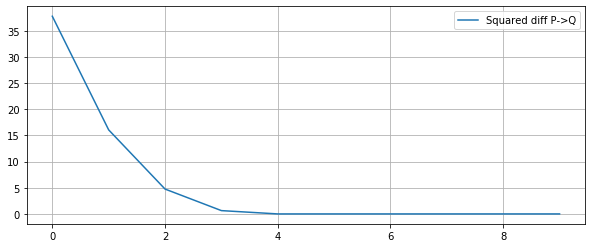

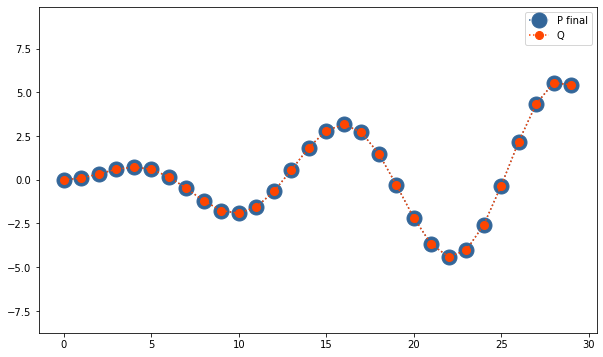

[37.7609616179743, 16.052894296516946, 4.747691495229578, 0.6307436032154973, 2.3534649635171557e-14, 2.0867504892199117e-14, 3.0269577207926576e-14, 3.127841565286951e-14, 3.210337588167061e-14, 2.9058550070732974e-14]
True Rotation Matrix: 
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]] 
vs True Translation: 
[[-2]
 [ 5]]
Calculated Transformation Matrix: 
[[ 0.70710678 -0.70710678 -2.        ]
 [ 0.70710678  0.70710678  5.        ]
 [ 0.          0.          1.        ]]


In [10]:
def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    R_res = np.identity(2, dtype=np.float)
    t_res = np.zeros((2,1), dtype = np.float)
    for i in range(iterations):
        center_of_P, P_centered = center_data(P_copy, exclude_indices=exclude_indices)
        correspondences = get_correspondence_indices(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)
        t = center_of_Q - R.dot(center_of_P)
        R_res = np.matmul(R, R_res)
        t_res = t + R.dot(t_res)
        P_copy = R.dot(P_copy) + t
        P_values.append(P_copy)
        corresp_values.append(corresp_values[-1])
    T_res = np.identity(3, dtype=np.float)
    T_res[:2,:2] = R_res
    T_res[:2,[2]] = t_res
    return P_values, norm_values, corresp_values, T_res

P_values, norm_values, corresp_values, T_res = icp_svd(P, Q)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)
print(f"True Rotation Matrix: \n{R_true} \nvs True Translation: \n{t_true}")
print(f"Calculated Transformation Matrix: \n{np.linalg.inv(T_res)}")

In [11]:
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-5, 35))

$\newcommand{\b}[1]{\boldsymbol{\mathrm{#1}}}$
$\newcommand{\R}{\boldsymbol{\mathrm{R}}}$
$\newcommand{\x}{\boldsymbol{\mathrm{x}}}$
$\newcommand{\h}{\boldsymbol{\mathrm{h}}}$
$\newcommand{\p}{\boldsymbol{\mathrm{p}}}$
$\newcommand{\q}{\boldsymbol{\mathrm{q}}}$
$\newcommand{\t}{\boldsymbol{\mathrm{t}}}$
$\newcommand{\J}{\boldsymbol{\mathrm{J}}}$
$\newcommand{\H}{\boldsymbol{\mathrm{H}}}$
$\newcommand{\E}{\boldsymbol{\mathrm{E}}}$
$\newcommand{\e}{\boldsymbol{\mathrm{e}}}$
$\newcommand{\n}{\boldsymbol{\mathrm{n}}}$
$\DeclareMathOperator*{\argmin}{arg\,min}$
$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$
# Non-linear Least-squares based ICP #
We can alternatively treat every iteration of ICP as a least squares minimization problem. The function we want to minimize is the squared sum of distances between the points of the scans:

\begin{equation}
E = \sum_i[\R\p_i + \t - \q_i]^2 \rightarrow \mathrm{min} 
\end{equation}

To minimize this function we update the pose $\b{R}$, $\b{t}$ (or alternatively represented as a vector $\b{x} = [x, y, \theta]^T$) to which we need to move scan $P$ to overlap it with a query scan $Q$. It is a non-linear function because of the rotation.

## Correspondeces ##
We look for correspondeces **without** moving the data to ensure zero-mean. Therefore the correspondences look worse than in SVD case, where we first ensured that both scans are zero-mean.

In [ ]:
correspondences = get_correspondence_indices(P, Q)
ax = plot_data(P, Q, "Moved data", "True data")
draw_correspondeces(P, Q, correspondences, ax)
plt.show()

## Minimization ##
We define $\p_i \in P$ to be points we want to match against $\q_j \in Q$. By "matching" we mean finding pose $\b{x} = [x, y, \theta]^T$ that minimizes the sum of squared lengths of the correspondences. Pose $\x$ can alternatively be resresented by a rotation matrix $\R = 
\begin{bmatrix}
    \cos\theta & - \sin\theta \\
    \sin\theta & \cos\theta
\end{bmatrix}$ and a translation vector $\t = [x, y]^T$. We will keep using these representations interchangibly throughtout these notes. 

We will further use the following notation: $\h_i(\x) = \R_\theta \p_i + \t$ to denote the points from scan $P$ transformed with $\R$ and $\t$. Additionally, we define error function $\e$ to be: 

\begin{eqnarray}
\e(\x) &=& \sum_{\{i,j\}\in C}{\e_{i,j}(\x)},\\
\e_{i,j}(\x) &=& \h_i(\x) - \q_j = \R_\theta \p_i + \t - \q_j
\end{eqnarray}


This allows us to formulate the minimization problem as follows:

\begin{eqnarray}
\b{x}_{query} 
&=& \argmin_{\x}\{\E(\x)\} \\
&=& \argmin_{\x}\{\sum_{\{i, j\} \in C}{\norm{\e_{i,j}(\x)}^2}\} \\ 
&=& \argmin_{\x}\{\sum_{\{i, j\} \in C}{\norm{\b{h}_i(\x) - \q_j}^2}\}
\end{eqnarray}

### Gauss Newton Method ###
We will be using Gauss Newton method for computing the least squares solution of our non-linear problem. We therefore linearize our function in the vicinity of $\x$. Solving non-linear least squares is equivalent to solving the following system of equations:

\begin{equation}
\H \Delta \x = - \E^\prime(\x),
\end{equation}

where $\Delta \x$ is the increment of the argument ($[\Delta x, \Delta y, \Delta \theta]$ in our case), $\H$ is the Hessian of $\E$ and $\E^\prime(\x)$ is the derivative over the function we are trying to minimize. 
We compute the gradient $\E^\prime(\x)$ as follows:

\begin{equation}
\E^\prime(\x) = \J(\x) \e(\x)
\end{equation}

In Gauss-Newton method we linearize the function around the considered point, which allows us to compute the Hessian as simple as: $\H = \J(\x)^T \J(\x)$

#### Jacobian ####
Both the Hessian and the gradient require the computation of a Jacobian. To compute a Jacobian we need a derivative of a rotation matrix:

\begin{equation}
\R_\theta^\prime
=\frac{\partial}{\partial \theta}
  \begin{bmatrix}
    \cos\theta & - \sin\theta \\
    \sin\theta & \cos\theta
  \end{bmatrix}
=\begin{bmatrix}
    -\sin\theta & - \cos\theta \\
    \cos\theta & -\sin\theta
  \end{bmatrix}
\end{equation}

In [ ]:
def dR(theta):
    return np.array([[-sin(theta), -cos(theta)],
                     [cos(theta),  -sin(theta)]])

def R(theta):
    return np.array([[cos(theta), -sin(theta)],
                     [sin(theta),  cos(theta)]])

Now we have everything to compute the Jacobian $\b{J}$ as follows:

\begin{eqnarray}
\b{J} = \frac{\partial \e_{i,j}(\x)}{\partial \x} = \frac{\partial \h_i(\x)}{\partial \x} 
&=& \Big(\frac{\partial \h_i(\x)}{\partial x}, \frac{\partial \h_i(\x)}{\partial y}, \frac{\partial \h_i(\x)}{\partial \theta}\Big) \\ 
&=&\Big(\b{I}, \R_\theta^\prime \p_i \Big) \\ 
&=&
\begin{bmatrix}
    1 & 0 & -\sin\theta\ p_i^x - \cos\theta\ p_i^y \\
    0 & 1 & \cos\theta\ p_i^x - \sin\theta\ p_i^y
\end{bmatrix}
\end{eqnarray}

In [ ]:
def jacobian(x, p_point):
    theta = x[2]
    J = np.zeros((2, 3))
    J[0:2, 0:2] = np.identity(2)
    J[0:2, [2]] = dR(0).dot(p_point)
    return J

def error(x, p_point, q_point):
    rotation = R(x[2])
    translation = x[0:2]
    prediction = rotation.dot(p_point) + translation
    return prediction - q_point

## Solving the Least Squares problem
Now that we know how to compute the Jacobian, we can compute the system of equations, solving which delivers the solution to our problem. We initialize Hessian $\H$ and gradient $\b{g}$ by zeros:

\begin{equation}
\b{H} = 
\begin{bmatrix}
    0 & 0 & 0 \\
    0 & 0 & 0 \\
    0 & 0 & 0
\end{bmatrix}, \ 
\b{g} = 
\begin{bmatrix}
    0 \\
    0 \\
    0
\end{bmatrix} \ 
\end{equation}

We now need to construct a system of equations solving which would give us the relative pose. **For every corresponding pair of points** do the following:

\begin{eqnarray}
\H &\rightarrow& \b{H} + \J^T \J \\
\b{g} &\rightarrow& \b{g} + \J^T \e
\end{eqnarray}

Now that the system of equation is ready, we can find the $\Delta\b{x}$ - the solution to the least squares problem:

\begin{equation}
\H \Delta\x = -\b{g} \Longrightarrow \Delta\x = -\b{H}^{-1}\b{g}
\end{equation}

This can be solved without actually inverting the matrix in reality.

In [ ]:
def prepare_system(x, P, Q, correspondences, kernel=lambda distance: 1.0):
    H = np.zeros((3, 3))
    g = np.zeros((3, 1))
    chi = 0
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        e = error(x, p_point, q_point)
        weight = kernel(e) # Please ignore this weight until you reach the end of the notebook.
        J = jacobian(x, p_point)
        H += weight * J.T.dot(J)
        g += weight * J.T.dot(e)
        chi += e.T * e
    return H, g, chi

def icp_least_squares(P, Q, corresp, iterations=30, kernel=lambda distance: 1.0):
    x = np.zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    for i in range(iterations):
        rot = R(x[2])
        t = x[0:2]
        correspondences = get_correspondence_indices(P_copy, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system(x, P, Q, correspondences, kernel)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        x[2] = atan2(sin(x[2]), cos(x[2])) # normalize angle
        chi_values.append(chi.item(0))
        x_values.append(x.copy())
        rot = R(x[2])
        t = x[0:2]
        P_copy = rot.dot(P.copy()) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

P_values, chi_values, corresp_values = icp_least_squares(P, Q, correspondences)
plot_values(chi_values, label="chi^2")
print(chi_values)

### Animate the result

In [ ]:
animate_results(P_values, Q, corresp_values, xlim=(-10, 35), ylim=(-10, 30))

# Using point to plane metric with Least Squares ICP
Point to point metric used before is not really the most optimal as can be seen above. It takes quite some iterations for the solution to converge. There is another metric which seems to work better. It is called "point to plane" metric. The idea here is that we still find the closest point, but the error is defined as a projection of the error onto the direction of the normal shot from the found point.

To start, we need to compute the normals of the resulting cloud.

The normal in this 2D case is simple to compute. For a vector $v = [x, y]^\top$ the normal is a vector $n_v = [-y, x]^\top$ as can be shown geometrically. 

In [ ]:
def compute_normals(points, step=1):
    normals = [np.array([[0, 0]])]
    normals_at_points = []
    for i in range(step, points.shape[1] - step):
        prev_point = points[:, i - step]
        next_point = points[:, i + step]
        curr_point = points[:, i]
        dx = next_point[0] - prev_point[0] 
        dy = next_point[1] - prev_point[1]
        normal = np.array([[0, 0],[-dy, dx]])
        normal = normal / np.linalg.norm(normal)
        normals.append(normal[[1], :])  
        normals_at_points.append(normal + curr_point)
    normals.append(np.array([[0, 0]]))
    return normals, normals_at_points

def plot_normals(normals, ax):
    label_added = False
    for normal in normals:
        if not label_added:
            ax.plot(normal[:,0], normal[:,1], color='grey', label='normals')
            label_added = True
        else:
            ax.plot(normal[:,0], normal[:,1], color='grey')
    ax.legend()
    return ax

normals, normals_to_draw = compute_normals(Q)
ax = plot_data(None, Q, None, 'Q')
ax = plot_normals(normals_to_draw, ax)
plt.show()

## Point to plane error metric

The error that we minimize is different. Before we minimized the Euclidean error between the 2 points, now we minimize this error projected onto the normal vector of one of the points.

\begin{equation}
E = \sum_i (\n_i \cdot (\R_\theta \p_i + \t - \q_j))^2 \rightarrow \mathrm{min},
\end{equation}

here $\n_i$ is the normal direction at the point $\q_i$. This leads to a changed jacobian that is not $2 \times 3$ as before, but $1 \times 3$.

## Point to plane Jacobian

In [ ]:
from sympy import init_printing, symbols, Matrix, cos as s_cos, sin as s_sin, diff
init_printing(use_unicode = True)

def RotationMatrix(angle):
    return Matrix([[s_cos(angle) , -s_sin(angle)], [s_sin(angle), s_cos(angle)]])

x, y, theta, n_x, n_y, p_x, p_y = symbols('x, y, \\theta, n_x, n_y, p_x, p_y')
t = Matrix([[x], [y]])
X = Matrix([x,y,theta])
n = Matrix([[n_x],[n_y]])
p = Matrix([[p_x], [p_y]])

error_point = RotationMatrix(theta) * p + t
error_normal = n.dot(RotationMatrix(theta) * p + t)

display()
J_point = diff(error_point, X).reshape(3,2).transpose()
J_normal = diff(error_normal, X).reshape(3,1).transpose()
display(Latex("Point to point Jacobian: "), J_point)
display(Latex("Point to plane Jacobian: "), J_normal)

## Faster convergence

This changes very little in the optimization procedure, but the convergence rate is much better.

In [ ]:
def prepare_system_normals(x, P, Q, correspondences, normals):
    H = np.zeros((3, 3))
    g = np.zeros((3, 1))
    chi = 0
    for (i, j), normal in zip(correspondences, normals):
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        e = normal.dot(error(x, p_point, q_point))
        J = normal.dot(jacobian(x, p_point))
        H += J.T.dot(J)
        g += J.T.dot(e)
        chi += e.T * e
    return H, g, chi

def icp_normal(P, Q, corresp, normals, iterations=20):
    x = np.zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_latest = P.copy()
    corresp_values = []
    for i in range(iterations):
        rot = R(x[2])
        t = x[0:2]
        correspondences = get_correspondence_indices(P_latest, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system_normals(x, P, Q, correspondences, normals)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        x[2] = atan2(sin(x[2]), cos(x[2])) # normalize angle
        chi_values.append(chi.item(0)) # add error to list of errors
        x_values.append(x.copy())
        rot = R(x[2])
        t = x[0:2]
        P_latest = rot.dot(P.copy()) + t
        P_values.append(P_latest)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

P_values, chi_values, corresp_values = icp_normal(P, Q, correspondences, normals)
plot_values(chi_values, label="chi^2")

In [ ]:
animate_results(P_values, Q, corresp_values, xlim=(-10, 35), ylim=(-10, 20))

# Dealing with outliers
If we corrupt our data, it gets harder for all of these algorithms to reason about it. 

Let's say, there is a couple pretty bad outliers in the $P$ data:

In [ ]:
# Introduce an outlier.
P_outliers = P.copy()
P_outliers[:, 10] = np.array([-10, 30])
P_outliers[:, 20] = np.array([0, 40])

In [ ]:
center_of_P_outliers = np.array([P_outliers.mean(axis=1)]).T
center_of_Q = np.array([Q.mean(axis=1)]).T
P_centered_outliers = P_outliers - center_of_P_outliers
Q_centered = Q - center_of_Q

In [ ]:
correspondences = get_correspondence_indices(P_centered_outliers, Q_centered)
ax = plot_data(P_centered_outliers, Q_centered,
               label_1='P centered',
               label_2='Q centered')
draw_correspondeces(P_centered_outliers, Q_centered, correspondences, ax)
plt.show()

## We cannot just run our methods without modification
If we try to run any of the methods above without modification, they will fail as the outliers will "drag" the solution away from the one that looks visually the best. That is because the outliers generate quite a big error that becomes part of the optimization process, which tries to satisfy these new constraints.

#### Let's see what will happen if we just use the vanilla point-to-point ICP

In [ ]:
P_values, chi_values, corresp_values = icp_least_squares(P_outliers, Q, correspondences)
plot_values(chi_values, label="chi^2")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

#### What about the point-to-plane ICP?

In [ ]:
P_values, chi_values, corresp_values = icp_normal(P_outliers, Q, correspondences, normals, iterations=30)
plot_values(chi_values, label="chi^2")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

In [ ]:
P_values, norm_values, corresp_values = icp_svd(P_outliers, Q, correspondences)
plot_values(norm_values, label="Norm values")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

### All three methods fail without an adaptation
As we can see, all methods failed to converge to a good-looking solution just as we have predicted. So what can we do about it?

## Robust kernels to give outliers less weight
There is a notion of "robust kernels" that are usually used for dealing with outliers. The idea is simple: we want to reduce the influence of the data that we deem "bad" on the final solution. There is a lot of different kernels that one might use and looking at all of them is beyong the scope of this notebook.

#### Let's see them in practice
In this example, I will use an extremely simple kernel (not the best in general, but quite good for the sake of example). The kernel takes in the value of an error and returns a weight of $1$ if the error is below threshold and $0$ if it is above. Basically, it is a way of saying "I don't care about anything that is way too far away". Usually a less strict version of the kernel is used, but the idea is similar.

In [ ]:
from functools import partial
def kernel(threshold, error):
    if np.linalg.norm(error) < threshold:
        return 1.0
    return 0.0

P_values, chi_values, corresp_values = icp_least_squares(
    P_outliers, Q, correspondences, kernel=partial(kernel, 10))
plot_values(chi_values, label="chi^2")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

## Yay!
We can see that our trick has worked! The kernel downweighted the outliers and while they still have a correspondence, because they generate way too big of an error we disregard them in the optimization.

## Can we remove outliers using ICP based on SVD?
Yes and no. SVD-based ICP has two steps: centering the data using its mean and optimizing the rotation. Let's looks at both starting with the rotational part.

#### Rotational part
It is relatively simple to remove the outliers during the rotation optimization. Each point contributes to the update of the cross-covariance matrix. We can weight this contribution based on the provided kernel. With the kernel presented above we can exclude points that are too far apart from contributing to the update of the cross-covariance matrix, thus, removing them from the optimization. 

#### Translational part
This is the tricky part. As centering the data happens *before* we estimate correspondences and we define the outliers by the length of the correspondence, there is no way to know which of the data points are outliers. If we do nothing about it, we will *always* have a drift after the optimization. I don't know a nice solution to this, but we can apply a hacky one. We could do the following:
- Find the first mean as if there were no outliers
- While performing rotation on that iteration, mark the points that are outliers (now we have correspondences and can do this)
- Apply the found rotation and translation
- Repeat the procedure excluding the marked outlier points from computing the mean.

#### Let's see how this trick performs:

In [ ]:
P_values, norm_values, corresp_values = icp_svd(P_outliers, Q, correspondences, kernel=partial(kernel, 10))
plot_values(norm_values, label="Norm values")
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-10, 30))

## Yay again!
We can see that this trick works too! Only the first translation is affected by the outliers and the method converges to a relatively good solution.